# Практикум №2: Оцінювання важливості ознак і вибір значущих ознак (feature selection)

0. Імпорт залежностей.

In [1]:
import random
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    RFE,
    RFECV,
    SequentialFeatureSelector,
    SelectFromModel,
)
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

from mlxtend.feature_selection import ColumnSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from src.visualization.plot import plot_feature_count_to_f1

random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

## Breast Cancer Wisconsin (Diagnostic)

1. Завнтажити датасет

In [2]:
heart_disease = pd.read_csv("https://archive.ics.uci.edu/static/public/45/data.csv")

features_count = len(heart_disease.columns)

heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [3]:
heart_disease["num"].unique()

array([0, 2, 1, 3, 4])

<Axes: >

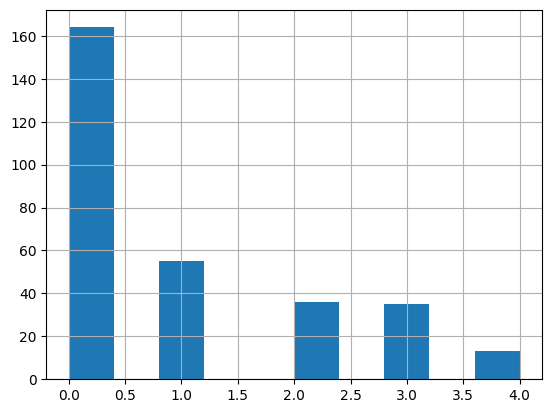

In [4]:
heart_disease["num"].hist()

In [5]:
heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [6]:
heart_disease.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [7]:
heart_disease[heart_disease.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


In [8]:
heart_disease = heart_disease.dropna()

In [9]:
x = heart_disease.drop(columns=["num"]).to_numpy()
y = heart_disease["num"].to_numpy()

2. Вибір значущих ознак через Univariate feature selection

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START selectkbest__k=4...........................................
[CV 1/5; 1/10] END ............selectkbest__k=4;, score=0.524 total time=   0.1s
[CV 2/5; 1/10] START selectkbest__k=4...........................................
[CV 2/5; 1/10] END ............selectkbest__k=4;, score=0.594 total time=   0.0s
[CV 3/5; 1/10] START selectkbest__k=4...........................................
[CV 3/5; 1/10] END ............selectkbest__k=4;, score=0.448 total time=   0.0s
[CV 4/5; 1/10] START selectkbest__k=4...........................................
[CV 4/5; 1/10] END ............selectkbest__k=4;, score=0.446 total time=   0.0s
[CV 5/5; 1/10] START selectkbest__k=4...........................................
[CV 5/5; 1/10] END ............selectkbest__k=4;, score=0.518 total time=   0.0s
[CV 1/5; 2/10] START selectkbest__k=5...........................................
[CV 1/5; 2/10] END ............selectkbest__k=5;

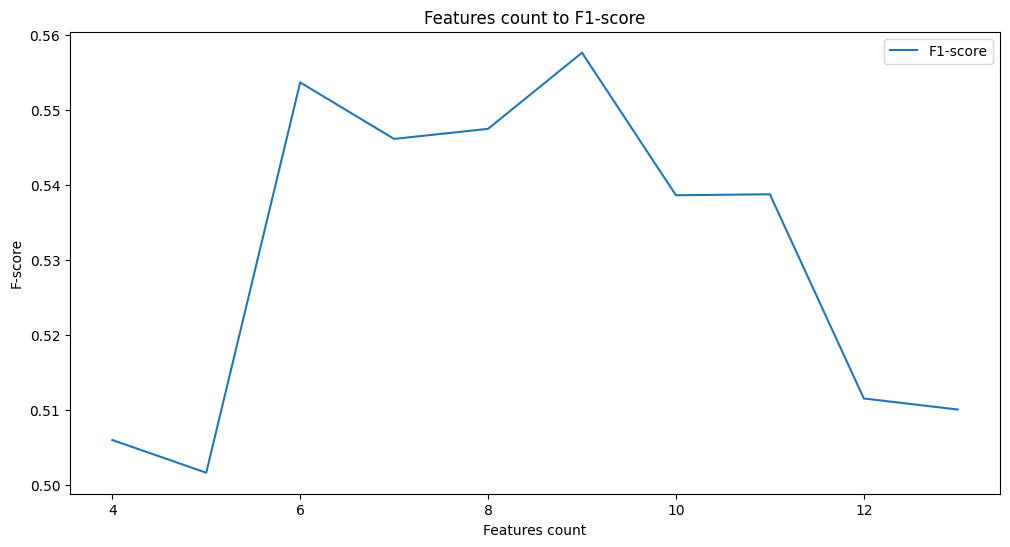

In [10]:
pipe = make_pipeline(
    SelectKBest(f_classif),
    StandardScaler(),
    RandomForestClassifier(),
    # MLPClassifier(
    #     hidden_layer_sizes=[1024, 512, 256, 128, 64, 32, 16, 8],
    #     random_state=random_seed,
    #     learning_rate_init=0.001,
    #     max_iter=1000,
    # ),
)

param_grid = {
    "selectkbest__k": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["selectkbest__k"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

3. Вибір значущих ознак через RFE

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START rfe__n_features_to_select=4................................
[CV 1/5; 1/10] END .rfe__n_features_to_select=4;, score=0.453 total time=   0.5s
[CV 2/5; 1/10] START rfe__n_features_to_select=4................................
[CV 2/5; 1/10] END .rfe__n_features_to_select=4;, score=0.524 total time=   0.5s
[CV 3/5; 1/10] START rfe__n_features_to_select=4................................
[CV 3/5; 1/10] END .rfe__n_features_to_select=4;, score=0.479 total time=   0.5s
[CV 4/5; 1/10] START rfe__n_features_to_select=4................................
[CV 4/5; 1/10] END .rfe__n_features_to_select=4;, score=0.541 total time=   0.5s
[CV 5/5; 1/10] START rfe__n_features_to_select=4................................
[CV 5/5; 1/10] END .rfe__n_features_to_select=4;, score=0.508 total time=   0.5s
[CV 1/5; 2/10] START rfe__n_features_to_select=5................................
[CV 1/5; 2/10] END .rfe__n_features_to_select=5;

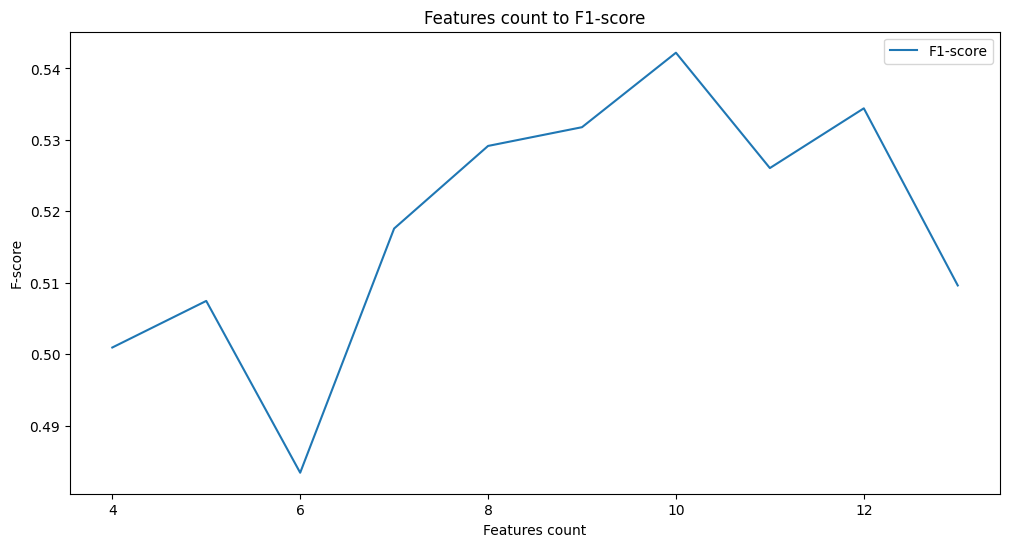

In [11]:
pipe = make_pipeline(
    StandardScaler(),
    RFE(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "rfe__n_features_to_select": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["rfe__n_features_to_select"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

4. Вибір значущих ознак через RFECV

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 1/5; 1/10] END rfecv__min_features_to_select=4;, score=0.551 total time=   2.6s
[CV 2/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 2/5; 1/10] END rfecv__min_features_to_select=4;, score=0.550 total time=   2.6s
[CV 3/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 3/5; 1/10] END rfecv__min_features_to_select=4;, score=0.490 total time=   2.6s
[CV 4/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 4/5; 1/10] END rfecv__min_features_to_select=4;, score=0.467 total time=   2.6s
[CV 5/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 5/5; 1/10] END rfecv__min_features_to_select=4;, score=0.554 total time=   2.6s
[CV 1/5; 2/10] START rfecv__min_features_to_select=5............................
[CV 1/5; 2/10] END rfecv__min_fea

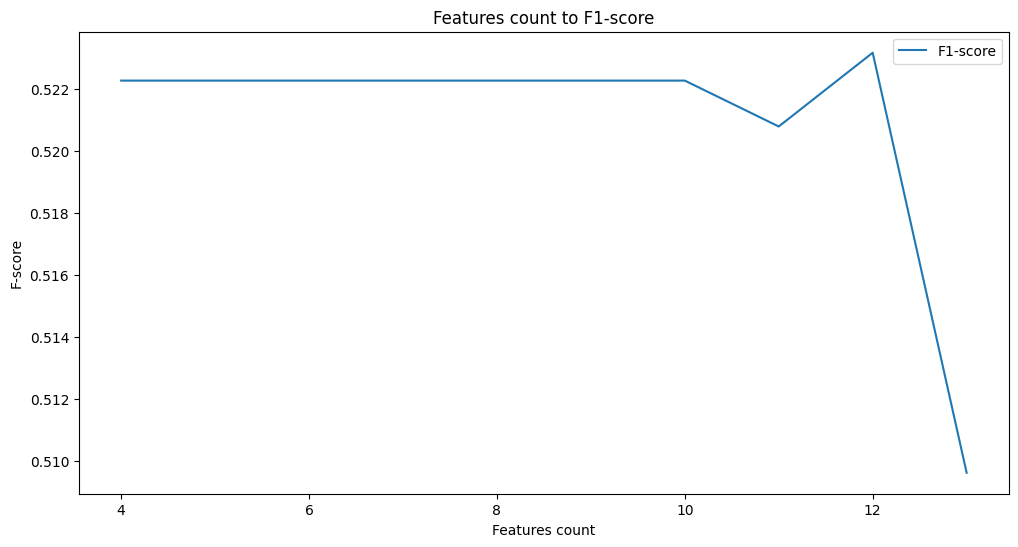

In [12]:
pipe = make_pipeline(
    StandardScaler(),
    RFECV(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "rfecv__min_features_to_select": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["rfecv__min_features_to_select"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

5. Вибір значущих ознак через forward Sequential Feature Selection

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 1/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.492 total time=   9.1s
[CV 2/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 2/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.533 total time=   9.2s
[CV 3/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 3/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.497 total time=   9.2s
[CV 4/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 4/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.467 total time=   9.4s
[CV 5/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 5/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.518 total time=   9.0s
[CV 1/5; 2/5] START sequential

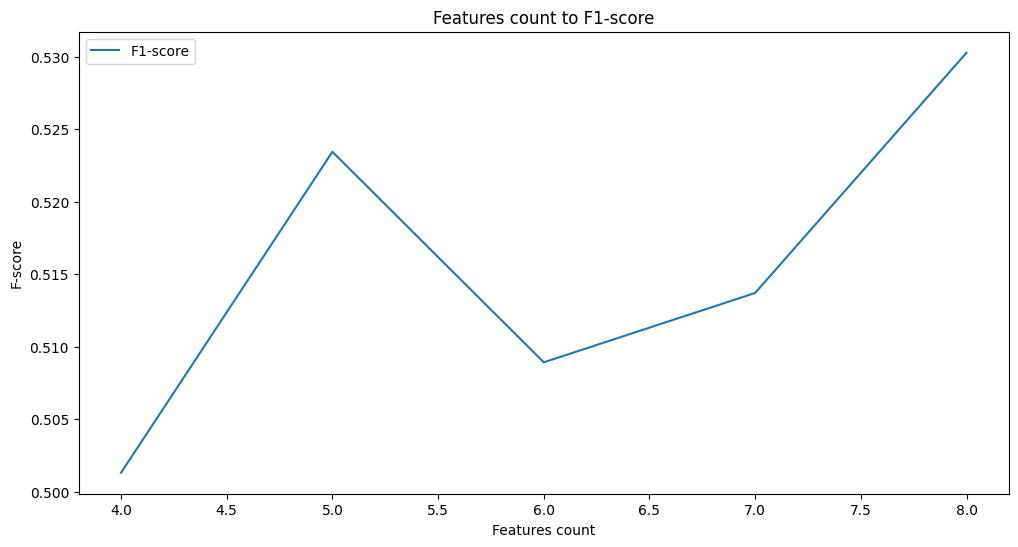

In [13]:
pipe = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        estimator=RandomForestClassifier(random_state=random_seed)
    ),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sequentialfeatureselector__n_features_to_select": [4, 5, 6, 7, 8],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["sequentialfeatureselector__n_features_to_select"]
    for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

6. Вибір значущих ознак через backward Sequential Feature Selection

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 1/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.465 total time=  17.9s
[CV 2/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 2/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.542 total time=  17.9s
[CV 3/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 3/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.499 total time=  17.9s
[CV 4/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 4/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.423 total time=  18.2s
[CV 5/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 5/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.521 total time=  18.5s
[CV 1/5; 2/5] START sequential

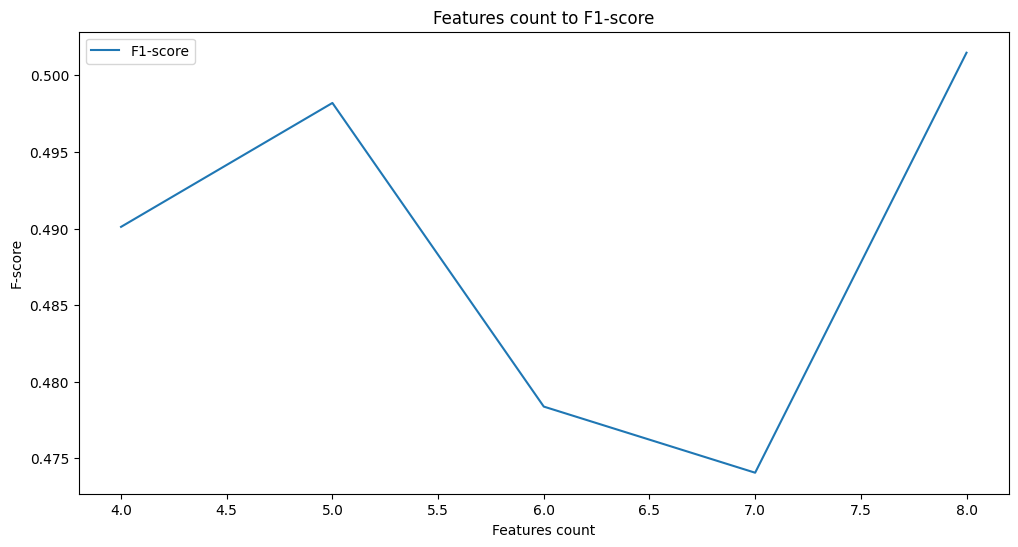

In [14]:
pipe = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        estimator=RandomForestClassifier(random_state=random_seed), direction="backward"
    ),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sequentialfeatureselector__n_features_to_select": [4, 5, 6, 7, 8],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["sequentialfeatureselector__n_features_to_select"]
    for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

7. Вибір значущих ознак через SelectFromModel logistic regression

In [15]:
pipe = make_pipeline(
    StandardScaler(),
    SelectFromModel(estimator=LogisticRegression(solver="lbfgs", max_iter=500)),
    LogisticRegression(solver="lbfgs", max_iter=500),
)

cross_val_score(pipe, x, y).mean()

0.582316384180791

8. Вибір значущих ознак через SelectFromModel random forest

In [16]:
pipe = make_pipeline(
    StandardScaler(),
    SelectFromModel(
        estimator=RandomForestClassifier(random_state=random_seed)
    ),
    RandomForestClassifier(random_state=random_seed),
)

cross_val_score(pipe, x, y).mean()

0.5487005649717513

9. Оцінити важливість ознак, використовуючи алгоритми, реалізовані в mlxtend python (ColumnSelector)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 1/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.401 total time=   0.0s
[CV 2/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 2/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.370 total time=   0.0s
[CV 3/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 3/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.389 total time=   0.0s
[CV 4/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 4/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.435 total time=   0.0s
[CV 5/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 5/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.351 total time=   0.0s
[CV 1/5; 2/3] START columnselector__cols=(2, 3, 4)..............................
[CV 1/5; 2/3] END columnselector__cols=(2, 3, 4);

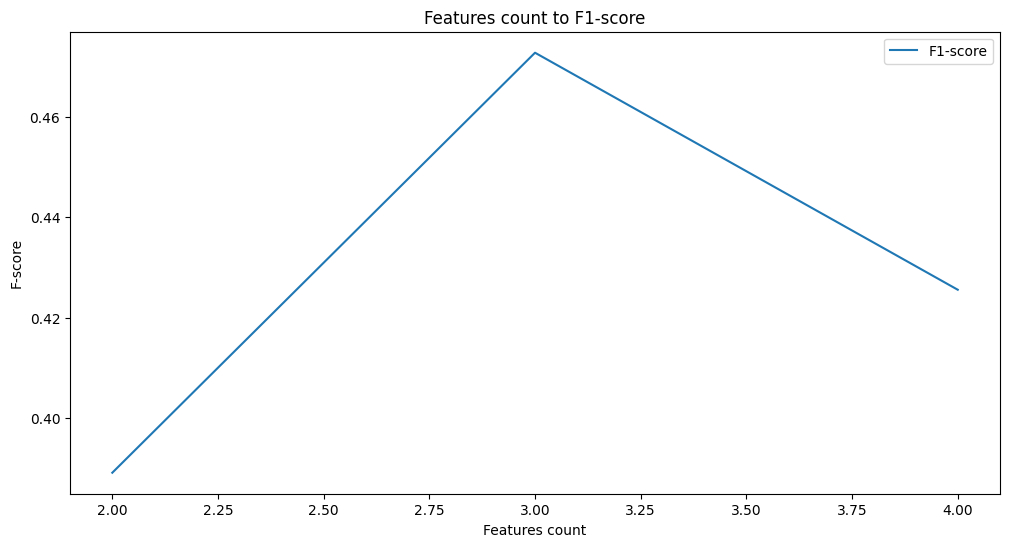

In [17]:
pipe = make_pipeline(
    StandardScaler(),
    ColumnSelector(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "columnselector__cols": [(0, 1), (2, 3, 4), (5, 6, 7, 8)],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [len(it["columnselector__cols"]) for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

10. Оцінити важливість ознак, використовуючи алгоритми, реалізовані в mlxtend python (SequentialFeatureSelector)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 1/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.492 total time=   9.7s
[CV 2/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 2/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.533 total time=   9.6s
[CV 3/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 3/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.497 total time=   9.7s
[CV 4/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 4/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.467 total time=   9.7s
[CV 5/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 5/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.518 total time=   9.5s
[CV 1/5; 2/5] START sequentialfeatureselector__k_features=5.....................

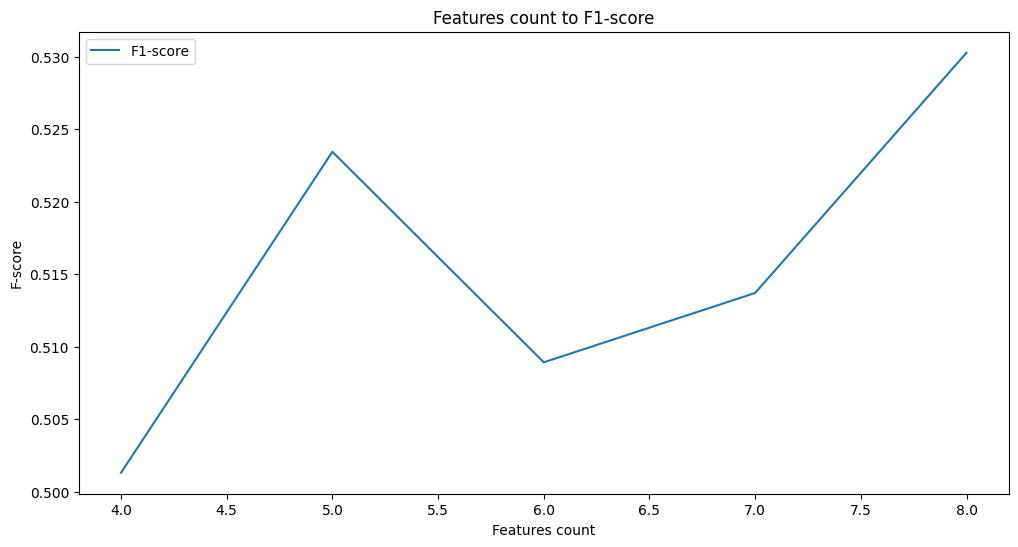

In [18]:
pipe = make_pipeline(
    StandardScaler(),
    SFS(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sequentialfeatureselector__k_features": [4, 5, 6, 7, 8],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["sequentialfeatureselector__k_features"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

## Згенерований датасет

1. Завнтажити датасет

In [19]:
x, y = make_classification(
    n_samples=200,  
    n_features=20, 
    n_informative=5,  
    n_redundant=3, 
    random_state=random_seed,  
)

2. Вибір значущих ознак через Univariate feature selection

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START selectkbest__k=4...........................................
[CV 1/5; 1/10] END ............selectkbest__k=4;, score=0.875 total time=   0.0s
[CV 2/5; 1/10] START selectkbest__k=4...........................................
[CV 2/5; 1/10] END ............selectkbest__k=4;, score=0.900 total time=   0.0s
[CV 3/5; 1/10] START selectkbest__k=4...........................................
[CV 3/5; 1/10] END ............selectkbest__k=4;, score=0.825 total time=   0.0s
[CV 4/5; 1/10] START selectkbest__k=4...........................................
[CV 4/5; 1/10] END ............selectkbest__k=4;, score=0.771 total time=   0.0s
[CV 5/5; 1/10] START selectkbest__k=4...........................................
[CV 5/5; 1/10] END ............selectkbest__k=4;, score=0.749 total time=   0.0s
[CV 1/5; 2/10] START selectkbest__k=5...........................................
[CV 1/5; 2/10] END ............selectkbest__k=5;

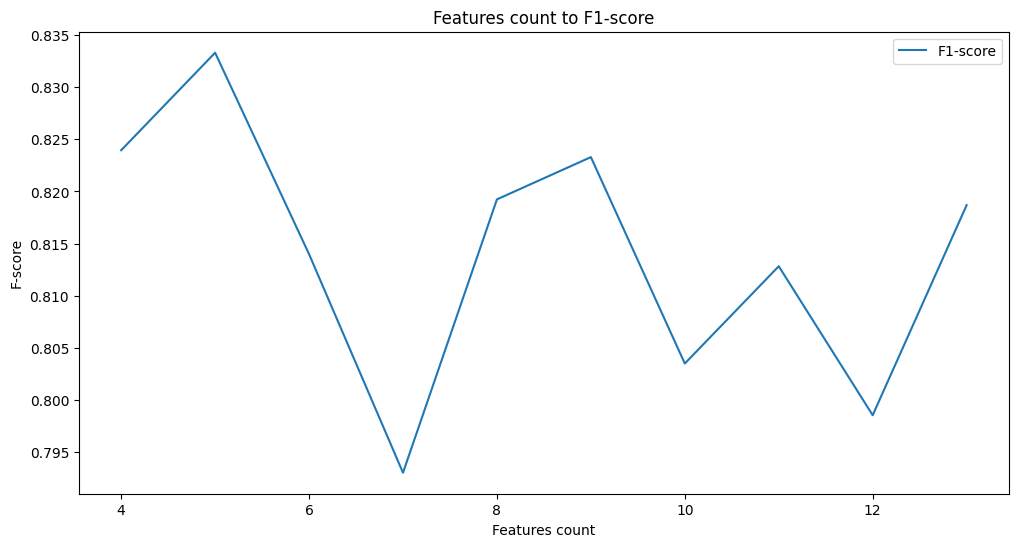

In [20]:
pipe = make_pipeline(
    SelectKBest(f_classif),
    StandardScaler(),
    RandomForestClassifier(),
)

param_grid = {
    "selectkbest__k": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["selectkbest__k"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

3. Вибір значущих ознак через RFE

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START rfe__n_features_to_select=4................................
[CV 1/5; 1/10] END .rfe__n_features_to_select=4;, score=0.747 total time=   0.9s
[CV 2/5; 1/10] START rfe__n_features_to_select=4................................
[CV 2/5; 1/10] END .rfe__n_features_to_select=4;, score=0.850 total time=   0.8s
[CV 3/5; 1/10] START rfe__n_features_to_select=4................................
[CV 3/5; 1/10] END .rfe__n_features_to_select=4;, score=0.848 total time=   0.9s
[CV 4/5; 1/10] START rfe__n_features_to_select=4................................
[CV 4/5; 1/10] END .rfe__n_features_to_select=4;, score=0.874 total time=   0.8s
[CV 5/5; 1/10] START rfe__n_features_to_select=4................................
[CV 5/5; 1/10] END .rfe__n_features_to_select=4;, score=0.821 total time=   0.8s
[CV 1/5; 2/10] START rfe__n_features_to_select=5................................
[CV 1/5; 2/10] END .rfe__n_features_to_select=5;

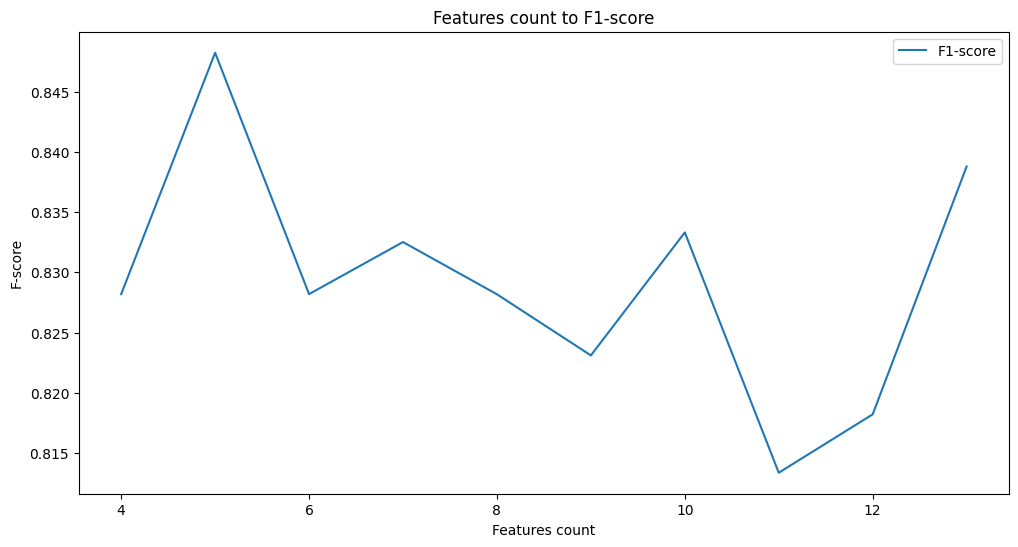

In [21]:
pipe = make_pipeline(
    StandardScaler(),
    RFE(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "rfe__n_features_to_select": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [it["rfe__n_features_to_select"] for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

4. Вибір значущих ознак через RFECV

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 1/5; 1/10] END rfecv__min_features_to_select=4;, score=0.875 total time=   4.8s
[CV 2/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 2/5; 1/10] END rfecv__min_features_to_select=4;, score=0.824 total time=   4.4s
[CV 3/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 3/5; 1/10] END rfecv__min_features_to_select=4;, score=0.848 total time=   4.7s
[CV 4/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 4/5; 1/10] END rfecv__min_features_to_select=4;, score=0.824 total time=   4.8s
[CV 5/5; 1/10] START rfecv__min_features_to_select=4............................
[CV 5/5; 1/10] END rfecv__min_features_to_select=4;, score=0.794 total time=   4.9s
[CV 1/5; 2/10] START rfecv__min_features_to_select=5............................
[CV 1/5; 2/10] END rfecv__min_fea

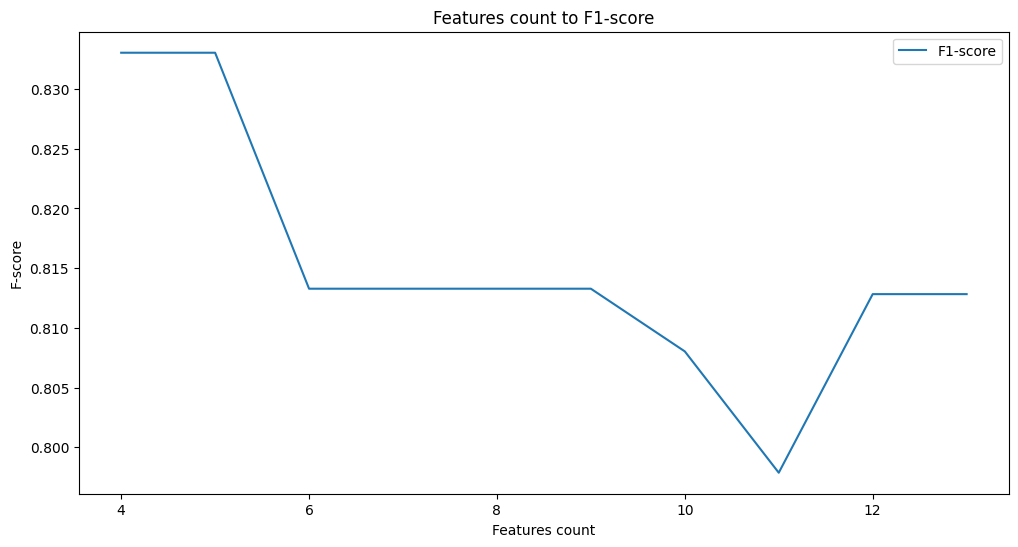

In [22]:
pipe = make_pipeline(
    StandardScaler(),
    RFECV(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "rfecv__min_features_to_select": np.arange(4, features_count, 1),
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["rfecv__min_features_to_select"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

5. Вибір значущих ознак через forward Sequential Feature Selection

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 1/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.875 total time=  15.4s
[CV 2/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 2/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.850 total time=  15.6s
[CV 3/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 3/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.798 total time=  15.7s
[CV 4/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 4/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.848 total time=  15.9s
[CV 5/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 5/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.821 total time=  15.5s
[CV 1/5; 2/5] START sequential

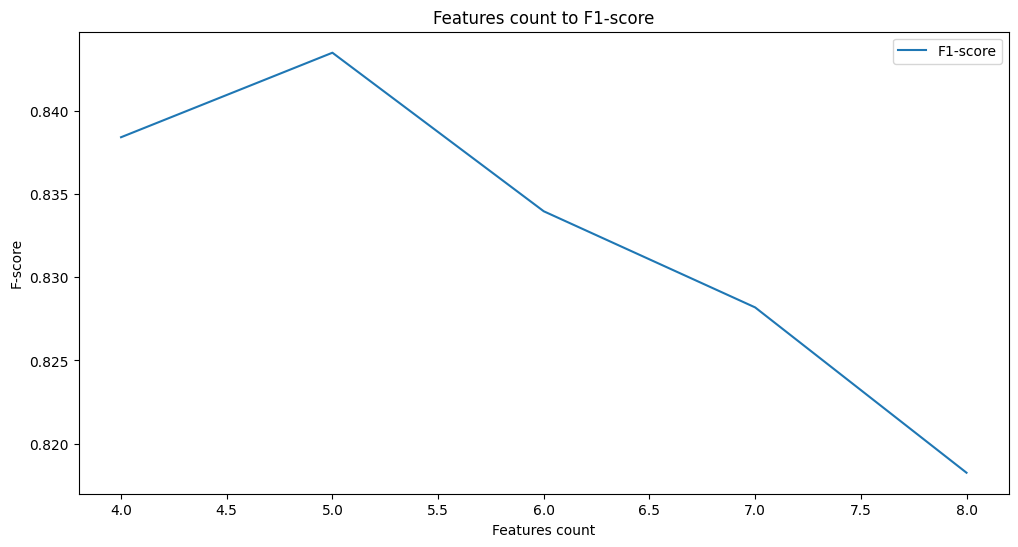

In [23]:
pipe = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        estimator=RandomForestClassifier(random_state=random_seed)
    ),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sequentialfeatureselector__n_features_to_select": [4, 5, 6, 7, 8],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["sequentialfeatureselector__n_features_to_select"]
    for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

6. Вибір значущих ознак через backward Sequential Feature Selection

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 1/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.875 total time=  45.2s
[CV 2/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 2/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.771 total time=  45.2s
[CV 3/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 3/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.771 total time=  45.6s
[CV 4/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 4/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.848 total time=  45.5s
[CV 5/5; 1/5] START sequentialfeatureselector__n_features_to_select=4...........
[CV 5/5; 1/5] END sequentialfeatureselector__n_features_to_select=4;, score=0.821 total time=  45.7s
[CV 1/5; 2/5] START sequential

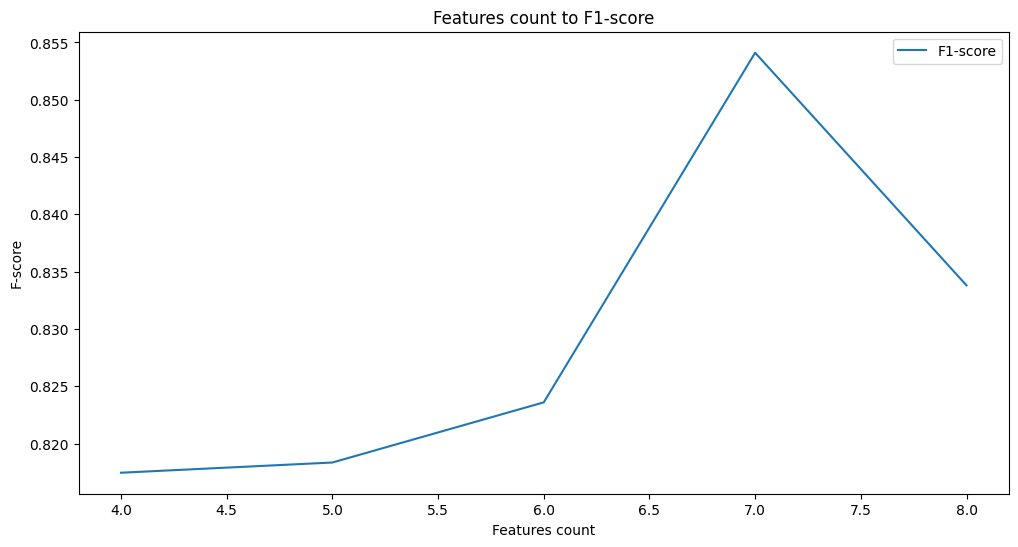

In [24]:
pipe = make_pipeline(
    StandardScaler(),
    SequentialFeatureSelector(
        estimator=RandomForestClassifier(random_state=random_seed), direction="backward"
    ),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sequentialfeatureselector__n_features_to_select": [4, 5, 6, 7, 8],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["sequentialfeatureselector__n_features_to_select"]
    for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

7. Вибір значущих ознак через SelectFromModel logistic regression

In [25]:
pipe = make_pipeline(
    StandardScaler(),
    SelectFromModel(estimator=LogisticRegression(solver="lbfgs", max_iter=500)),
    LogisticRegression(solver="lbfgs", max_iter=500),
)

cross_val_score(pipe, x, y).mean()

0.675

8. Вибір значущих ознак через SelectFromModel random forest

In [26]:
pipe = make_pipeline(
    StandardScaler(),
    SelectFromModel(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

cross_val_score(pipe, x, y).mean()

0.8400000000000001

9. Оцінити важливість ознак, використовуючи алгоритми, реалізовані в mlxtend python (ColumnSelector)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 1/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.499 total time=   0.1s
[CV 2/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 2/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.517 total time=   0.0s
[CV 3/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 3/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.525 total time=   0.0s
[CV 4/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 4/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.499 total time=   0.0s
[CV 5/5; 1/3] START columnselector__cols=(0, 1).................................
[CV 5/5; 1/3] END ..columnselector__cols=(0, 1);, score=0.475 total time=   0.0s
[CV 1/5; 2/3] START columnselector__cols=(2, 3, 4)..............................
[CV 1/5; 2/3] END columnselector__cols=(2, 3, 4);

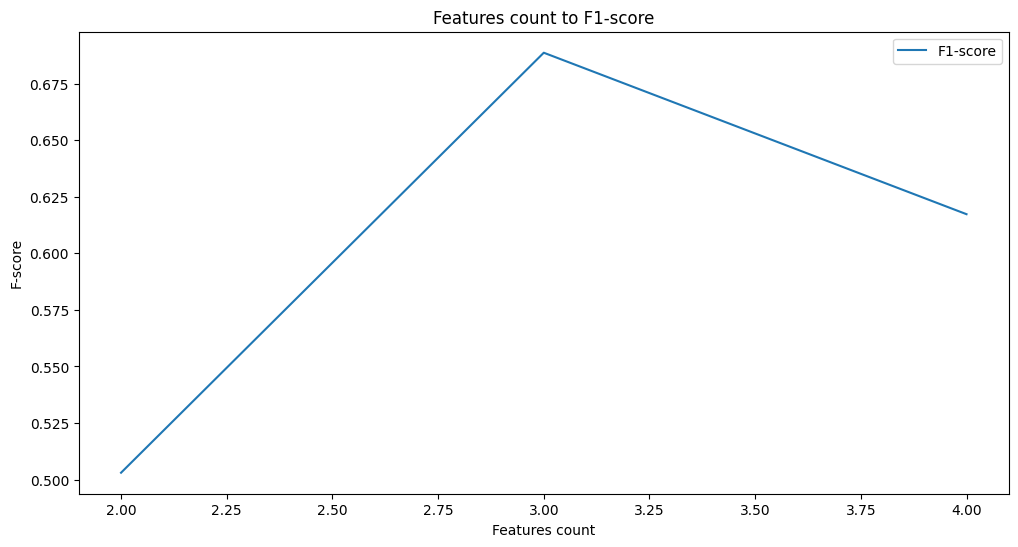

In [27]:
pipe = make_pipeline(
    StandardScaler(),
    ColumnSelector(),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "columnselector__cols": [(0, 1), (2, 3, 4), (5, 6, 7, 8)],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [len(it["columnselector__cols"]) for it in search.cv_results_["params"]]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

10. Оцінити важливість ознак, використовуючи алгоритми, реалізовані в mlxtend python (SequentialFeatureSelector)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 1/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.875 total time=  15.5s
[CV 2/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 2/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.850 total time=  15.5s
[CV 3/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 3/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.798 total time=  15.5s
[CV 4/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 4/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.848 total time=  15.4s
[CV 5/5; 1/5] START sequentialfeatureselector__k_features=4.....................
[CV 5/5; 1/5] END sequentialfeatureselector__k_features=4;, score=0.821 total time=  15.4s
[CV 1/5; 2/5] START sequentialfeatureselector__k_features=5.....................

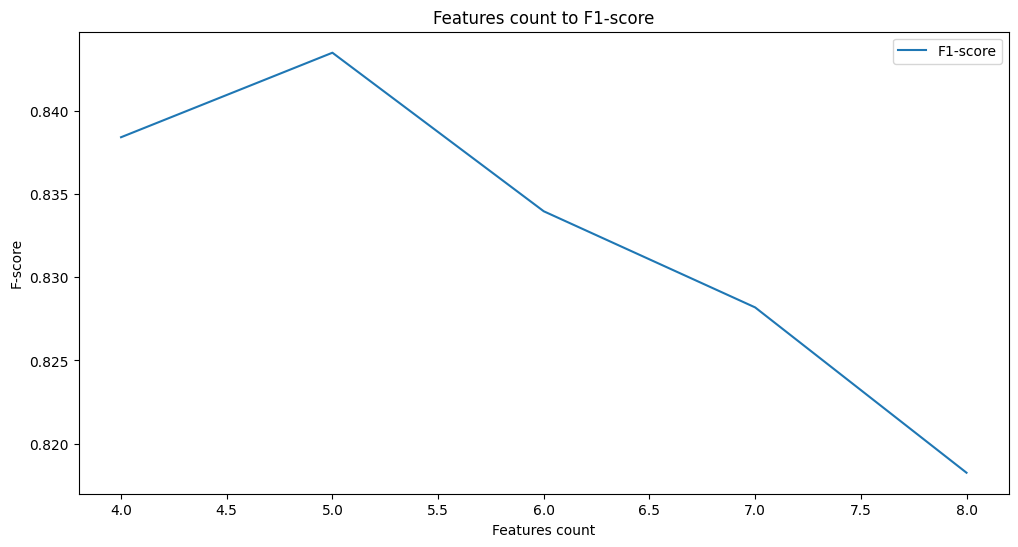

In [28]:
pipe = make_pipeline(
    StandardScaler(),
    SFS(estimator=RandomForestClassifier(random_state=random_seed)),
    RandomForestClassifier(random_state=random_seed),
)

param_grid = {
    "sequentialfeatureselector__k_features": [4, 5, 6, 7, 8],
}

search = GridSearchCV(pipe, param_grid, scoring="f1_weighted", verbose=10)

search.fit(x, y)

used_params = [
    it["sequentialfeatureselector__k_features"] for it in search.cv_results_["params"]
]

plot_feature_count_to_f1(used_params, search.cv_results_["mean_test_score"])

## Висновки

* Для Breast Cancer датасету f1 score коливається між 0.4 та 0.6.
* Для Breast Cancer датасету різні алгоритми вибору ознак повертають різну оптимальну к-сть ознак.
* Для Breast Cancer датасету оптималтна к-сть ознак ~~ 6.
* Для зненерованого датасету усі алгоритми визначили правильну кількість значущих ознак, тобто 5.